**Import necessary libraries**

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import notebook
import jupyterlab
import networkx as nx
import community.community_louvain as community_louvain  # pip install python-louvain
from pyvis.network import Network
from IPython.display import display, IFrame, clear_output
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

**Import evaluation function**

In [7]:
from scripts.eval_script import run_eval

**Setup matplotlib and seaborn**

In [8]:
%matplotlib inline
sns.set(style="whitegrid")

**Species Distribution Histogram for Top 30 Species**

/scratch/achoksi/job_41572705/ipykernel_1866108/4112225342.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=species_counts.index, y=species_counts.values, palette="viridis")


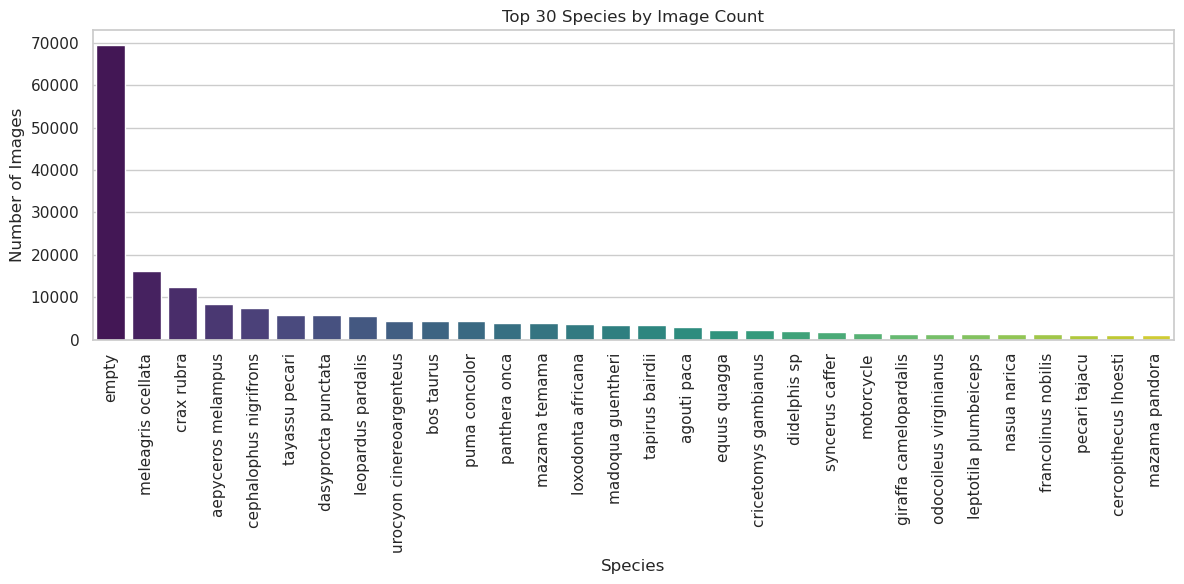

In [9]:
metadata_path = "data/iwildcam_v2.0/metadata.csv"
categories_path = "data/iwildcam_v2.0/categories.csv"

metadata = pd.read_csv(metadata_path)
categories = pd.read_csv(categories_path)

# Merge on 'y' which is the species ID in both dataframes
metadata = metadata.merge(categories[['y', 'name']], on='y', how='left')

# Count top 30 species by name
species_counts = metadata['name'].value_counts().head(30) ##Number can be changed depending on how many species are wanted in graph

plt.figure(figsize=(12, 6))
sns.barplot(x=species_counts.index, y=species_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Top 30 Species by Image Count")
plt.ylabel("Number of Images")
plt.xlabel("Species")
plt.tight_layout()
plt.show()

**Time of Day Distribution Histogram**

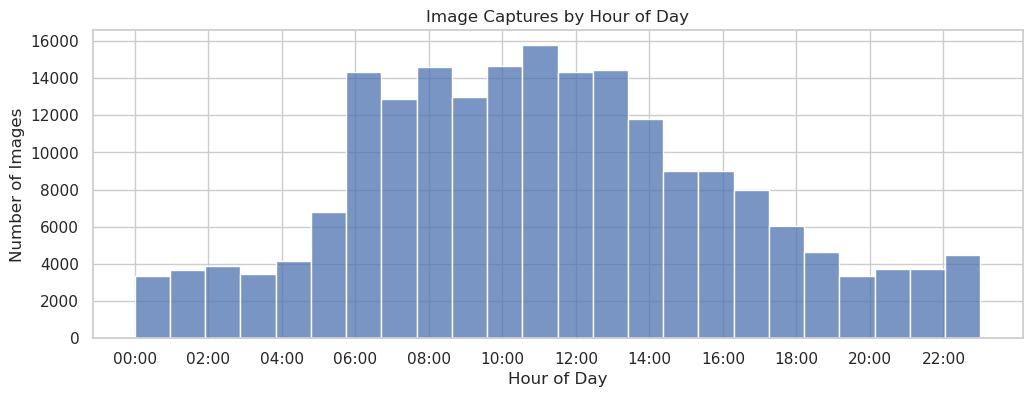

In [10]:

# Convert 'datetime' to pandas datetime if not already
metadata['datetime'] = pd.to_datetime(metadata['datetime'], errors='coerce')

# Extract hour of day
metadata['hour'] = metadata['datetime'].dt.hour

plt.figure(figsize=(12, 4))
sns.histplot(metadata['hour'].dropna(), bins=24, kde=False)

plt.title("Image Captures by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Images")

# Set x-axis ticks and labels as time strings
plt.xticks(
    ticks=range(0, 24, 2),
    labels=[f"{h:02d}:00" for h in range(0, 24, 2)]
)

plt.show()

**Knowledge Graph View**

In [12]:
metadata = pd.read_csv("data/iwildcam_v2.0/metadata.csv")
categories = pd.read_csv("data/iwildcam_v2.0/categories.csv")

id_to_species_name = dict(zip(categories['y'], categories['name']))

with open("gps_locations.json") as f:
    gps_locations = json.load(f)

with open("data/iwildcam_v2.0/taxon_id_to_name.json") as f:
    taxon_id_to_name = json.load(f)

kg_edges = pd.read_csv("data/iwildcam_v2.0/dataset_subtree.csv")


def label_species(species_id):
    try:
        key = str(int(species_id))
    except:
        return str(species_id)
    return taxon_id_to_name.get(key, f"Species {key}")

def label_location(location_id):
    try:
        key = str(int(float(location_id)))
    except:
        return str(location_id)
    loc = gps_locations.get(key, None)
    if loc:
        return f"Loc {key} ({loc['latitude']:.2f}, {loc['longitude']:.2f})"
    else:
        return f"Loc {key}"

def label_node(node_id, datatype):
    """
    Return human-readable label for a node based on its datatype.
    """
    if datatype == "id":
        return label_species(node_id)
    elif datatype == "location":
        return label_location(node_id)
    elif datatype == "image":
        return f"Image {node_id}"
    elif datatype == "time":
        return f"Time {node_id}"
    else:
        return str(node_id)


G = nx.MultiDiGraph()

for _, row in kg_edges.iterrows():
    h, t = row['h'], row['t']
    datatype_h = row['datatype_h']
    datatype_t = row['datatype_t']

    # Add edge with attributes
    G.add_edge(h, t,
               relation=row['r'],
               datatype_h=datatype_h,
               datatype_t=datatype_t,
               split=row['split'])
    
    # Add or update node labels
    if 'label' not in G.nodes[h]:
        G.nodes[h]['label'] = label_node(h, datatype_h)
    if 'label' not in G.nodes[t]:
        G.nodes[t]['label'] = label_node(t, datatype_t)

print(f"Graph built with {len(G.nodes())} nodes and {len(G.edges())} edges.")


G_undirected = G.to_undirected()
partition = community_louvain.best_partition(G_undirected)
print(f"Detected {len(set(partition.values()))} communities.")


H = nx.DiGraph()
for comm_id in set(partition.values()):
    H.add_node(comm_id)

for u, v, data in G.edges(data=True):
    cu = partition[u]
    cv = partition[v]
    if cu != cv:
        if H.has_edge(cu, cv):
            H[cu][cv]['weight'] += 1
        else:
            H.add_edge(cu, cv, weight=1)

print(f"Aggregated graph with {len(H.nodes())} community nodes and {len(H.edges())} edges.")

with open("node_community_map.json", "w") as f:
    json.dump(partition, f)

community_to_nodes = {}
for node, comm in partition.items():
    community_to_nodes.setdefault(comm, []).append(node)

# --- Visualization helper ---
def explore_community_custom_style(community_id):
    community_nodes = set(community_to_nodes[community_id])
    neighbors = set()
    for n in community_nodes:
        neighbors.update(G.neighbors(n))
        neighbors.update(G.predecessors(n))
    expanded_nodes = community_nodes.union(neighbors)
    subgraph = G.subgraph(expanded_nodes)

    net = Network(height="750px", width="100%", notebook=True, directed=True)
    net.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=250, damping=0.7)

    color_map = {
        'type1': '#FF5733',  # red
        'type2': '#33CFFF',  # blue
        'type3': '#75FF33',  # green
        'unknown': '#BBBBBB'  # grey
    }

    for n, data in subgraph.nodes(data=True):
        label = data.get("label", str(n))
        node_type = data.get('datatype_h', 'unknown')
        color = color_map.get(node_type, '#BBBBBB')
        title = "<br>".join(f"<b>{k}:</b> {v}" for k, v in data.items()) or "No metadata"
        net.add_node(str(n), label=label, title=title, color=color, shape='dot', size=15)

    for u, v, data in subgraph.edges(data=True):
        label = data.get("relation", "")
        net.add_edge(str(u), str(v), title=label)

        
    filename = f"community_custom_style_{community_id}.html"
    net.show(filename)

# --- Interactive loop ---
while True:
    user_input = input(f"Enter community ID to explore (0 to {max(partition.values())}), or 'q' to quit: ")
    if user_input.lower() == 'q':
        print("Exiting.")
        break
    try:
        community_id = int(user_input)
        if community_id not in community_to_nodes:
            print(f"Community {community_id} does not exist. Try again.")
            continue

        clear_output(wait=True)  # Clear previous output before showing new graph
        explore_community_custom_style(community_id)
        display(IFrame(f"community_custom_style_{community_id}.html", width="100%", height="750px"))

    except ValueError:
        print("Please enter a valid integer community ID or 'q' to quit.")


community_custom_style_385.html


Enter community ID to explore (0 to 397), or 'q' to quit:  q


Exiting.


**Evaluate Model on chosen variants**

In [2]:
context_variants = {
#      <Variant name> : <Model Path>
#e.g.  'img_only': 'ckpts/best_model.pt'
}

args_dict = {
    'data_dir': 'data/iwildcam_v2.0/',
    'img_dir': 'data/iwildcam_v2.0/train/',
    'split': 'val', ##Change depending on which split to test on, e.g. val/test
    'seed': 813765,
    'debug': False,
    'no_cuda': False,
    'use_subtree': True,
    'batch_size': 16,
    'embedding_dim': 512,
    'location_input_dim': 2,
    'time_input_dim': 1,
    'mlp_location_numlayer': 3,
    'mlp_time_numlayer': 3,
    'img_embed_model': 'resnet50',
    'use_data_subset': False,
    'subset_size': 200,
}

results = {}

for variant, ckpt_path in context_variants.items():
    print(f"Evaluating {variant}...")
    args_dict['ckpt_path'] = ckpt_path
    eval_results = run_eval(args_dict)
    results[variant] = eval_results 

Evaluating loc_time...
args = {'data_dir': 'data/iwildcam_v2.0/', 'img_dir': 'data/iwildcam_v2.0/train/', 'split': 'val', 'seed': 813765, 'debug': False, 'no_cuda': False, 'use_subtree': True, 'batch_size': 16, 'embedding_dim': 512, 'location_input_dim': 2, 'time_input_dim': 1, 'mlp_location_numlayer': 3, 'mlp_time_numlayer': 3, 'img_embed_model': 'resnet50', 'use_data_subset': False, 'subset_size': 200, 'ckpt_path': 'ckpts/full_models/loc_time/best_model.pt'}
len(entity2id) = 511


100%|██████████| 203029/203029 [00:00<00:00, 1065907.65it/s]


No. of target categories = 182
length of image2id dataset = 14961
len(val_image_to_id_dataset) = 14961
ckpt loaded...


100%|██████████| 936/936 [02:14<00:00,  6.95it/s]


Eval., split: val, image to id, Average acc: 65.25, F1 macro: 34.11


**Model Accuracy for each Context Variant**

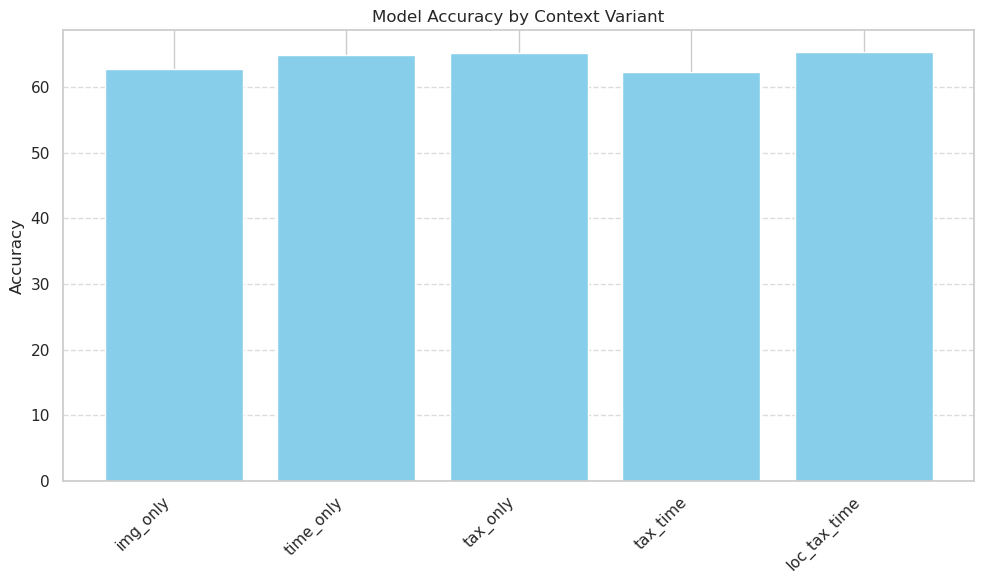

In [5]:
# Sort results alphabetically or however you want
variants = list(results.keys())
accuracies = [results[v]['accuracy'] for v in variants]

plt.figure(figsize=(10, 6))
plt.bar(variants, accuracies, color='skyblue')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Context Variant')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Confusion Matrix for Top 20 Most Frequent Species**

Available model variants:
- img_only
- time_only
- tax_only
- tax_time
- loc_tax_time


Enter the model variant you want to analyze:  tax_time


Using top 20 most frequent species for confusion matrix.


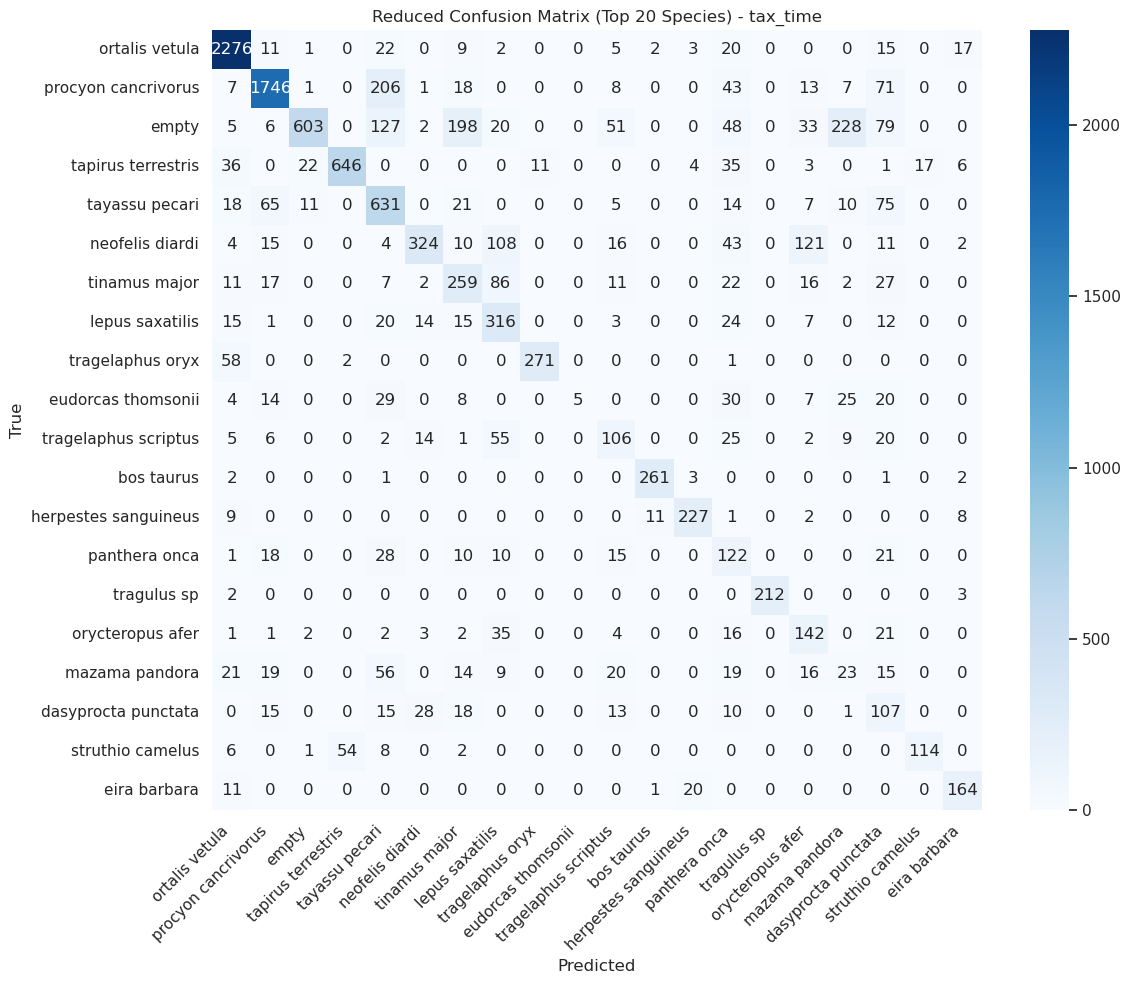

In [6]:


print("Available model variants:")
for variant in context_variants:
    print("-", variant)

selected_variant = input("Enter the model variant you want to analyze: ").strip()
if selected_variant not in context_variants:
    raise ValueError(f"Invalid variant: {selected_variant}")

categories_df = pd.read_csv("data/iwildcam_v2.0/categories.csv")
id_to_name = dict(zip(categories_df["y"], categories_df["name"]))

y_true = np.array(results[selected_variant]['y_true'], dtype=int)
y_pred = np.array(results[selected_variant]['y_pred'], dtype=int)

N = 20  # you can change this to 10, 50, etc.
freq = Counter(y_true)
top_species = [label for label, _ in freq.most_common(N)]

print(f"Using top {N} most frequent species for confusion matrix.")

mask = np.isin(y_true, top_species)
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_species)

labels_names = [id_to_name.get(int(label), f"Unknown({label})") for label in top_species]

# Plot reduced confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_names, yticklabels=labels_names, cmap='Blues')
plt.title(f"Reduced Confusion Matrix (Top {N} Species) - {selected_variant}")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Precision, Recall, and F1 Score for each Context Variant**

/scratch/achoksi/job_41549881/species-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/achoksi/job_41549881/species-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/achoksi/job_41549881/species-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric

              Precision    Recall  F1 Score
Variant                                    
img_only       0.281348  0.276159  0.253102
time_only      0.310256  0.304360  0.280312
tax_only       0.321577  0.281190  0.267837
tax_time       0.326754  0.281495  0.267439
loc_tax_time   0.317059  0.272479  0.270593


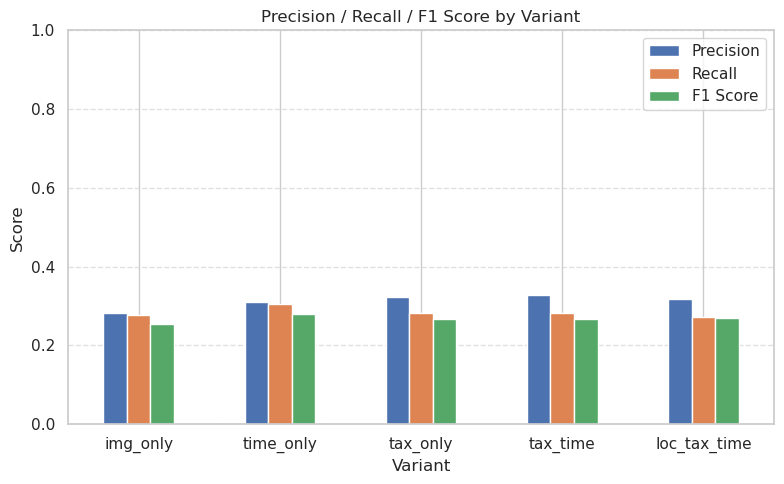

In [15]:

summary = {}

for variant, data in results.items():
    y_true = data["y_true"]
    y_pred = data["y_pred"]
    
    summary[variant] = {
        "Precision": precision_score(y_true, y_pred, average='macro'),
        "Recall": recall_score(y_true, y_pred, average='macro'),
        "F1 Score": f1_score(y_true, y_pred, average='macro'),
    }

df = pd.DataFrame(summary).T
df.index.name = "Variant"
print(df)

df.plot(kind='bar', figsize=(8, 5))
plt.title("Precision / Recall / F1 Score by Variant")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Top 1, Top 3, Top 5 Accuracy per Context Variant**

Available model variants:
- img_only
- time_only
- tax_only
- tax_time
- loc_tax_time


Enter the model variant you want to analyze:  tax_time


/scratch/achoksi/job_41549881/ipykernel_2865963/1626233466.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


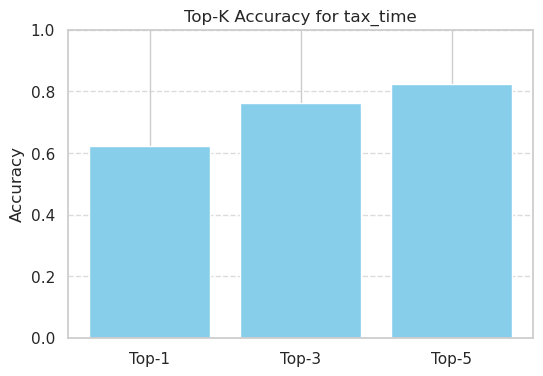

In [16]:

def topk_accuracy(logits, targets, ks=(1, 3, 5)):
    logits = torch.tensor(logits)
    targets = torch.tensor(targets)
    _, pred = logits.topk(max(ks), dim=1)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1).expand_as(pred))

    results = {}
    for k in ks:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        results[f'Top-{k}'] = (correct_k / targets.size(0)).item()
    return results

print("Available model variants:")
for variant in context_variants:
    print("-", variant)

selected_variant = input("Enter the model variant you want to analyze: ").strip()
if selected_variant not in context_variants:
    raise ValueError(f"Invalid variant: {selected_variant}")

topk_acc = topk_accuracy(results[selected_variant]['y_probs'], results[selected_variant]['y_true'])

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(topk_acc.keys(), topk_acc.values(), color='skyblue')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title(f'Top-K Accuracy for {selected_variant}')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Histogram of Accuracy and Population for Top 30 Most Accurate Species**

Available model variants:
- img_only
- time_only
- tax_only
- tax_time
- loc_tax_time


Enter the model variant you want to analyze:  loc_tax_time


Using top 30 most frequent species for accuracy and population plots.


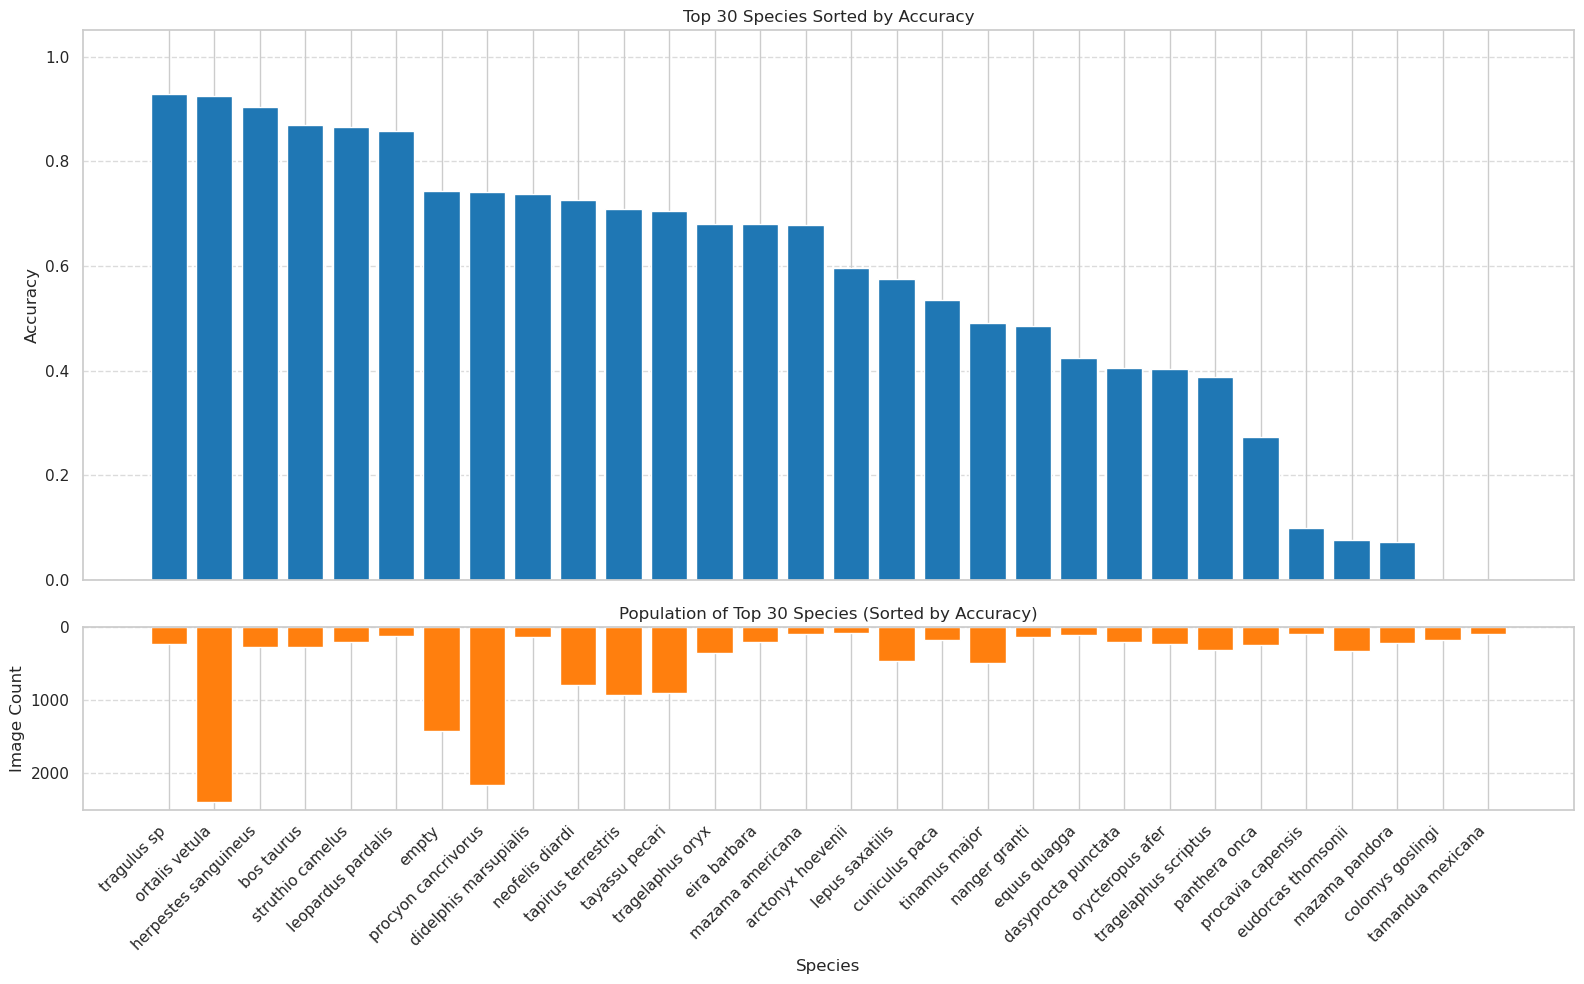

In [22]:

def plot_top_30_accuracy_and_population(y_true, y_pred, name_map, image_counts):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    class_ids = np.unique(y_true)
    
    per_class_accuracy = {}
    for cid in class_ids:
        mask = y_true == cid
        correct = (y_pred[mask] == cid).sum()
        total = mask.sum()
        acc = correct / total if total > 0 else 0.0
        per_class_accuracy[cid] = acc

    top_30 = sorted(per_class_accuracy.items(), key=lambda x: x[1], reverse=True)[:30]
    
    species_ids, accuracies = zip(*top_30)
    species_names = [name_map.get(str(cid), f"ID {cid}") for cid in species_ids]
    populations = [image_counts.get(cid, 0) for cid in species_ids]

    x = np.arange(len(species_names))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True,
                                   gridspec_kw={'height_ratios': [3, 1]})

    ax1.bar(x, accuracies, color='tab:blue')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1.05)
    ax1.set_title('Top 30 Species by Accuracy')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    ax2.bar(x, populations, color='tab:orange')
    ax2.set_ylabel('Image Count')
    ax2.set_xlabel('Species')
    ax2.set_title('Population of Top 30 Species (by accuracy)')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    plt.xticks(x, species_names, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

print("Available model variants:")
for variant in context_variants:
    print("-", variant)

selected_variant = input("Enter the model variant you want to analyze: ").strip()
if selected_variant not in context_variants:
    raise ValueError(f"Invalid variant: {selected_variant}")

N = 30

y_true = np.array(results[selected_variant]['y_true'], dtype=int)
y_pred = np.array(results[selected_variant]['y_pred'], dtype=int)

freq = Counter(y_true)
top_species = [label for label, _ in freq.most_common(N)]
print(f"Using top {N} most frequent species for accuracy and population plots.")

def compute_accuracy_for_species(y_true, y_pred, species_list):
    per_class_accuracy = {}
    for cid in species_list:
        mask = y_true == cid
        total = mask.sum()
        acc = (y_pred[mask] == cid).sum() / total if total > 0 else 0.0
        per_class_accuracy[cid] = acc
    return per_class_accuracy

per_class_accuracy = compute_accuracy_for_species(y_true, y_pred, top_species)

categories_df = pd.read_csv("data/iwildcam_v2.0/categories.csv")
id_to_name = dict(zip(categories_df["y"], categories_df["name"]))

sorted_species = sorted(per_class_accuracy.items(), key=lambda x: x[1], reverse=True)
species_ids_sorted, accuracies_sorted = zip(*sorted_species)

species_names_sorted = [id_to_name.get(cid, f"Unknown({cid})") for cid in species_ids_sorted]
populations_sorted = [freq[cid] for cid in species_ids_sorted]

x = np.arange(len(species_names_sorted))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

ax1.bar(x, accuracies_sorted, color='tab:blue')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1.05)
ax1.set_title(f'Top {N} Species Sorted by Accuracy')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2.bar(x, populations_sorted, color='tab:orange')
ax2.set_ylabel('Image Count')
ax2.set_xlabel('Species')
ax2.set_title(f'Population of Top {N} Species (Sorted by Accuracy)')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.invert_yaxis()  # This flips the population bars vertically

plt.xticks(x, species_names_sorted, rotation=45, ha='right')
plt.tight_layout()
plt.show()
